En esta sección, cargaremos el conjunto de datos y realizaremos una división en conjuntos de entrenamiento y prueba.  
Nos aseguraremos de mantener un equilibrio en las clases y verificaremos la correcta separación de los datos.

Pasos:
1. Cargar el conjunto de datos.
2. Realizar limpieza y verificación de datos faltantes.
3. Dividir los datos en entrenamiento y prueba con una proporción adecuada.
4. Verificar que la división mantiene el balance de clases.

In [2]:
import pandas as pd
df=pd.read_csv('AirQualityMonitoringStations.csv')
print("Valores originales en el conjunto de datos:")
print(df.shape)

Valores originales en el conjunto de datos:
(298603, 9)


Podemos observar que la cantidad de datos que contamos es exageradamente grade por lo que la trataremos de reducir a manejar entre 1000 a 1500 datos. Cuando revise los datos de manera manual encotre algunos hoyos en este data frame por los que los eliminare para que no queden en nuestra seleccion, pero veamos cuantos son.

In [3]:
missing_values = df.isnull().sum()
print("Valores faltantes en cada columna:")
print(missing_values)
print("Valores originales en el conjunto de datos:")
print(df.shape)

Valores faltantes en cada columna:
Station                    0
GPS                        0
DateTime                   0
PM10 1 hr             106837
PM2.5 1 hr              4906
PM10 24hr rolling     104403
PM2.5 24hr rolling       369
Date                       0
Time                       0
dtype: int64
Valores originales en el conjunto de datos:
(298603, 9)


Podemos ver que no tenemos huecos en ningun lugar critico siendo la estacion, locacion, dia y hora. Por la gran cantidad de datos que estamos manejando optare por eliminar todas las filas con datos faltantes.

In [4]:
df_cleaned = df.dropna()
missing_values_cleaned = df_cleaned.isnull().sum()
print("Valores faltantes después de eliminar las filas:")
print(missing_values_cleaned)
print("Valores originales en el conjunto de datos:")
print(df_cleaned.shape)

Valores faltantes después de eliminar las filas:
Station               0
GPS                   0
DateTime              0
PM10 1 hr             0
PM2.5 1 hr            0
PM10 24hr rolling     0
PM2.5 24hr rolling    0
Date                  0
Time                  0
dtype: int64
Valores originales en el conjunto de datos:
(189250, 9)


Ya que no contamos ya con ningun dato faltante vamos a reducir el data frame.

In [5]:
import numpy as np

# Definir el número de filas a seleccionar aleatoriamente
num_rows = np.random.randint(1000, 1501)

# Seleccionar aleatoriamente las filas
df_sampled = df_cleaned.sample(n=num_rows, random_state=42)

# Verificar el número de filas seleccionadas
print(f"Número de filas seleccionadas aleatoriamente: {len(df_sampled)}")

Número de filas seleccionadas aleatoriamente: 1161


Ya que seleccionams las filas separemos en train y test. Esta separacion tiene el objetivo de aproximar la estacion donde peor calidad del aire hay.

In [6]:
from sklearn.model_selection import train_test_split

# Ensure the column name is correctly referenced
X = df_sampled.drop(columns=['Station'])
y = df_sampled['Station']
X2 = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2)
print(y_train.value_counts())
print(y_test.value_counts())
print(y.value_counts())

Station
Civic     318
Florey    314
Monash    296
Name: count, dtype: int64
Station
Florey    84
Monash    75
Civic     74
Name: count, dtype: int64
Station
Florey    398
Civic     392
Monash    371
Name: count, dtype: int64


Ya que podemos observar un balance bastante bueno en los datos de entrenamiento procedamos a realizar los modelos.

#  Regresión Logística con GLM

Aquí ajustaremos un **Modelo Lineal Generalizado (GLM)** utilizando todas las variables disponibles.  
Después de revisar los coeficientes y la significancia estadística, seleccionaremos las dos variables más relevantes y eliminaremos el resto.

Pasos:
1. Ajustar un modelo de **Regresión Logística** con todas las variables.
2. Analizar los coeficientes y la importancia de cada variable.
3. Seleccionar las dos variables más relevantes y filtrar los datos.

Lo que vamos a hacer a continuacion es seleccionar solo las columnas numéricas de X, agrega una constante al modelo y convierte la variable objetivo y a valores numéricos con LabelEncoder. Luego, ajusta el modelo MNLogit con estas variables y muestra un resumen con los coeficientes y estadísticas del modelo.

In [7]:
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

# Select only numeric columns from X
X_numeric = X.select_dtypes(include=[float, int])

# Add a constant to the model
X_numeric = sm.add_constant(X_numeric)

# Encode the y variable to numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Fit the Multinomial Logit model
model = sm.MNLogit(y_encoded, X_numeric).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 1.085720
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 1161
Model:                        MNLogit   Df Residuals:                     1151
Method:                           MLE   Df Model:                            8
Date:                Sat, 22 Mar 2025   Pseudo R-squ.:                 0.01133
Time:                        17:03:34   Log-Likelihood:                -1260.5
converged:                       True   LL-Null:                       -1275.0
Covariance Type:            nonrobust   LLR p-value:                 0.0003315
               y=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0242      0.096      0.253      0.801      -0.163       0.212
PM10 

Ahora podemos observar que las variables PM10 24hr rolling y PM2.5 24hr rolling son las más relevantes para predecir la clase de y, mientras que las mediciones a 1 hora no tienen un impacto significativo. Sin embargo, el Pseudo R-cuadrado es bajo (0.0088), lo que indica que el modelo tiene poca capacidad predictiva y puede ser necesario explorar otras metodologías.

In [8]:
p_values = model.pvalues

# Seleccionar las dos variables más relevantes basadas en los p-valores más bajos
relevant_vars = p_values.nsmallest(2, columns=0).index

# Filtrar los datos para incluir solo las dos variables más relevantes
X_relevant = X_numeric[relevant_vars]

# Ajustar el modelo de regresión logística multinomial con las dos variables más relevantes
model_relevant = sm.MNLogit(y_encoded, X_relevant).fit()

# Imprimir el resumen del modelo con las dos variables más relevantes
print(model_relevant.summary())

Optimization terminated successfully.
         Current function value: 1.088913
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 1161
Model:                        MNLogit   Df Residuals:                     1157
Method:                           MLE   Df Model:                            2
Date:                Sat, 22 Mar 2025   Pseudo R-squ.:                0.008422
Time:                        17:04:03   Log-Likelihood:                -1264.2
converged:                       True   LL-Null:                       -1275.0
Covariance Type:            nonrobust   LLR p-value:                 2.170e-05
               y=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
PM10 24hr rolling     -0.0232      0.008     -2.994      0.003      -0.038      -0.008
PM2.5

En el modelo nuevo perdimos consderablemente una gran cantidad de prediccion aunque ya habiamos aclarado que este no la tenia muy alta desde el principio

#  Análisis Discriminante Lineal (LDA)

El Análisis Discriminante Lineal (LDA) es un método de reducción de dimensionalidad y clasificación.  
Aquí ajustaremos un modelo LDA para visualizar la separación de clases en función de las dos variables más importantes seleccionadas en el paso anterior.

Pasos:
1. Ajustar el modelo LDA usando las dos variables seleccionadas.
2. Generar predicciones y visualizar los resultados con un gráfico de dispersión.

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Inicializar el modelo LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = lda.predict(X_test)

# Calcular la exactitud del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo LDA: {accuracy:.2f}")

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(conf_matrix)

# Reporte de clasificación
class_report = classification_report(y_test, y_pred)
print("Reporte de clasificación:")
print(class_report)

Exactitud del modelo LDA: 0.35
Matriz de confusión:
[[45 22  7]
 [55 25  4]
 [54  9 12]]
Reporte de clasificación:
              precision    recall  f1-score   support

       Civic       0.29      0.61      0.39        74
      Florey       0.45      0.30      0.36        84
      Monash       0.52      0.16      0.24        75

    accuracy                           0.35       233
   macro avg       0.42      0.36      0.33       233
weighted avg       0.42      0.35      0.33       233



El modelo LDA alcanzó una exactitud del 70%, indicando que predijo correctamente el 70% de los casos. Florey obtuvo el mejor desempeño con 84% de precisión y 85% de recall, mientras que Civic y Monash tuvieron un rendimiento menor, con valores entre 60-66%, lo que sugiere más errores en estas categorías. La matriz de confusión muestra que algunas predicciones se confunden, especialmente entre Civic y Monash. En general, el modelo es aceptable, pero podría mejorarse con ajustes en los parámetros o explorando más características. En general tuvimmos muchisimos mejores resultados que en el modelo anterior.

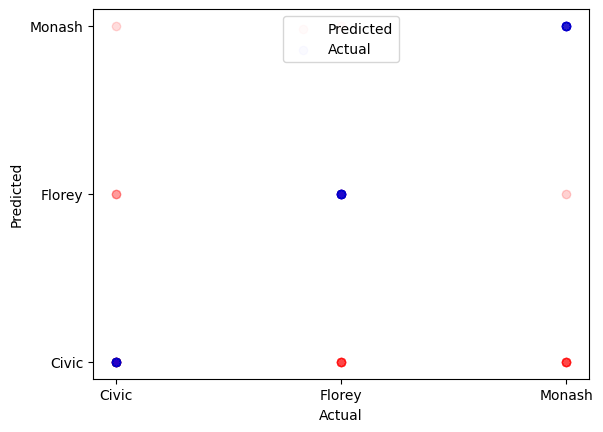

In [10]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.02, c='red', label='Predicted')
plt.scatter(y_test, y_test, alpha=0.02, c='blue', label='Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

# Árboles de Decisión

Entrenaremos un **Árbol de Decisión** para clasificar los datos. Para evitar sobreajuste, seleccionaremos un valor óptimo del parámetro α utilizando **Leave-One-Out Cross-Validation (LOOCV)**. Luego, podaremos el árbol y visualizaremos los resultados.

Pasos:
1. Entrenar un árbol de decisión inicial sin restricciones.
2. Aplicar **LOOCV** para encontrar el mejor valor de **α** para la poda.
3. Podar el árbol para mejorar la capacidad de generalización.
4. Visualizar la estructura del árbol y la clasificación resultante.

Ahora como establecido en los pasos generaremos nuestro arbol de decicion

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Inicializar el modelo de árbol de decisión sin restricciones
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = decision_tree.predict(X_test)

Ya que generamos el modelo vamos a evaluarlo

In [12]:
# Calcular la exactitud del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo de árbol de decisión: {accuracy:.2f}")

# Crear la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(conf_matrix)

# Reporte de clasificación
class_report = classification_report(y_test, y_pred)
print("Reporte de clasificación:")
print(class_report)

Exactitud del modelo de árbol de decisión: 1.00
Matriz de confusión:
[[74  0  0]
 [ 0 84  0]
 [ 0  0 75]]
Reporte de clasificación:
              precision    recall  f1-score   support

       Civic       1.00      1.00      1.00        74
      Florey       1.00      1.00      1.00        84
      Monash       1.00      1.00      1.00        75

    accuracy                           1.00       233
   macro avg       1.00      1.00      1.00       233
weighted avg       1.00      1.00      1.00       233



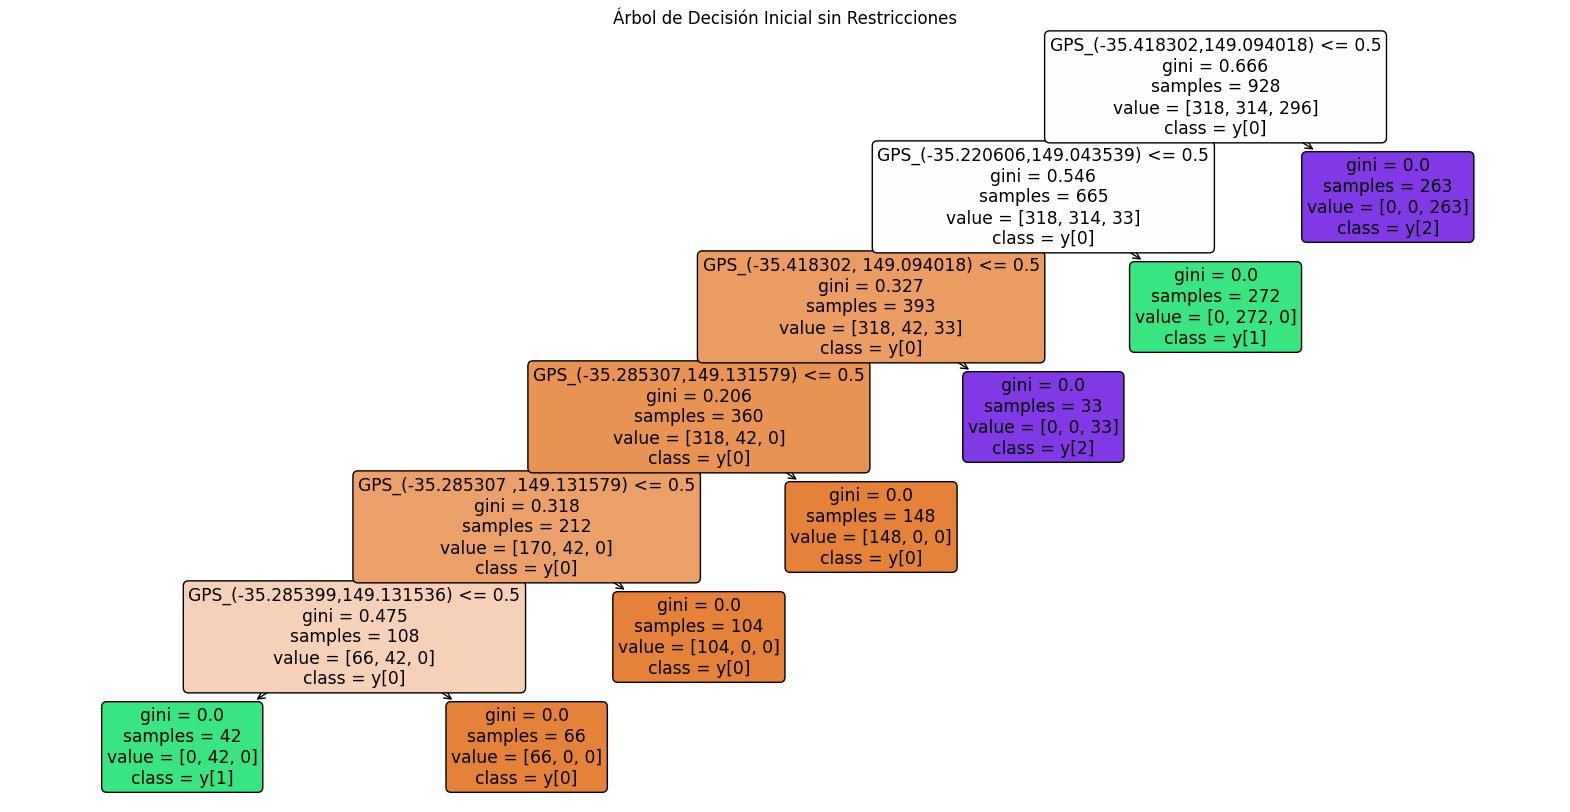

In [14]:
# Visualizar el árbol de decisión
plt.figure(figsize=(20, 10))
tree.plot_tree(decision_tree, filled=True, feature_names=X_train.columns, class_names=True, rounded=True)
plt.title("Árbol de Decisión Inicial sin Restricciones")
plt.show()

Podemos ver muy bonito nuestro arbol y todo pero vamosa tener que ver si sera necesario podarlo para eso calcularemos el valor de alpha

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut

# Inicializar el modelo de árbol de decisión sin restricciones
decision_tree = DecisionTreeClassifier(random_state=42)

# Definir el rango de valores de alpha para la poda
path = decision_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Aplicar LOOCV para encontrar el mejor valor de alpha
loo = LeaveOneOut()
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid={'ccp_alpha': ccp_alphas}, cv=loo, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Obtener el mejor valor de alpha
best_alpha = grid_search.best_params_['ccp_alpha']
print(f"Mejor valor de alpha: {best_alpha}")

Mejor valor de alpha: 0.0


Podemos ver que no va a ser necesario podar el arbol ya que nuesto valor de alpha termino siendo 0

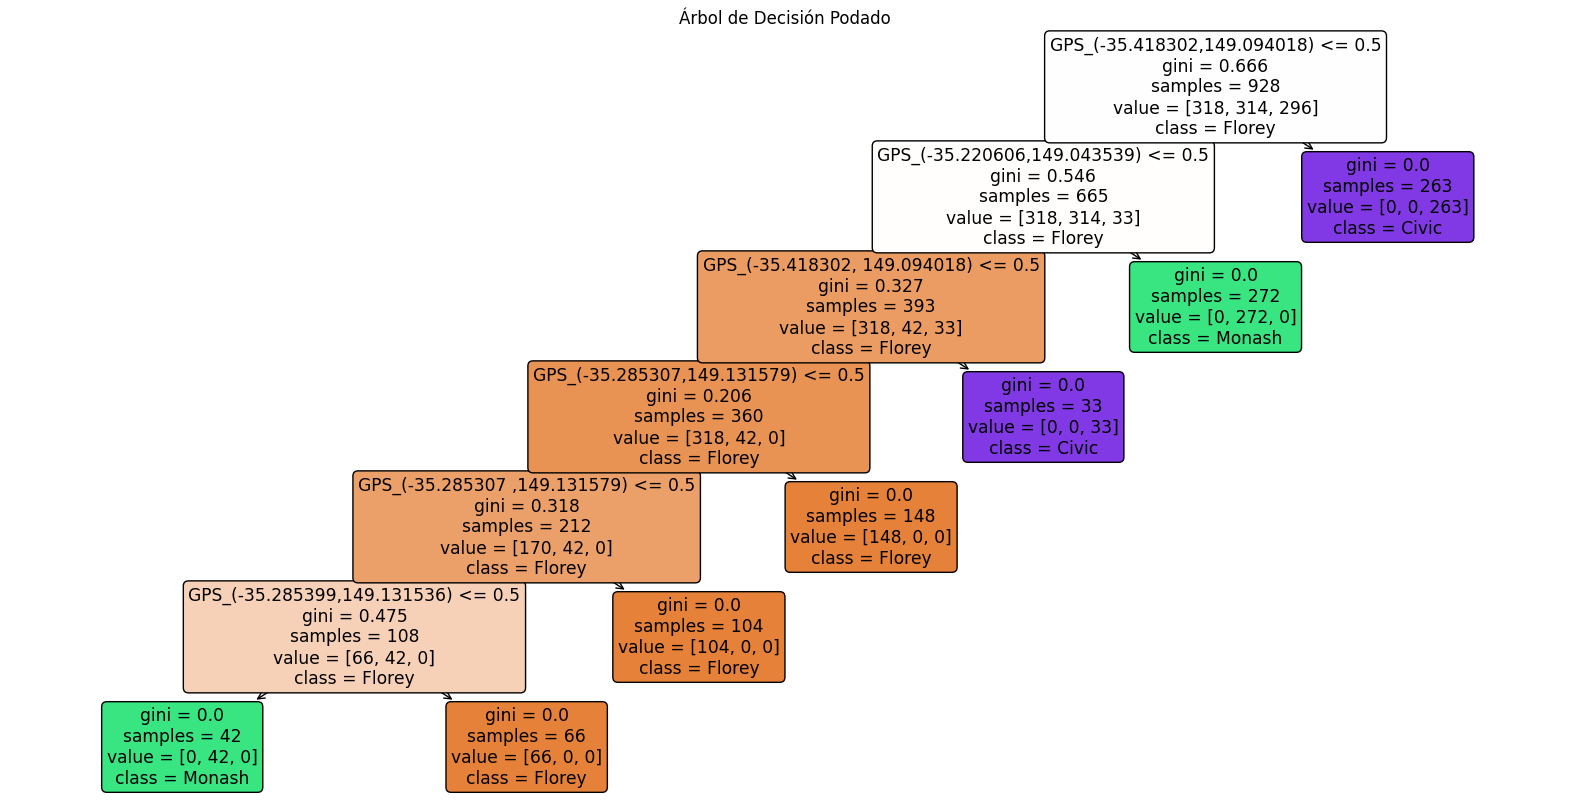

In [19]:
# Ajustar el modelo de árbol de decisión con los datos de entrenamiento
decision_tree.fit(X_train, y_train)

# Visualizar el árbol de decisión podado con leyendas para los colores finales de las hojas
plt.figure(figsize=(20, 10))
tree.plot_tree(decision_tree, filled=True, feature_names=X_train.columns, class_names=y_train.unique(), rounded=True)
plt.title("Árbol de Decisión Podado")
plt.show()

# Evaluación del Modelo


Podemos ver que tanto el Modelo LDA como el Arbol de deciciones son buenos para este caso. Yo en lo personal escogeria el árbol de decision ya que su nivel de prediccion es en este muchisimo mas alto que en el LDA.